In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from utils import getClientData

machine = 'Compressore 3'
data = getClientData(machine)
timestamps = data.index.values
measurements = [
  'Current (A)',
  'CosPhi (Units)',
  'Energy Consumption (kWh)',
  'Reactive Energy (VARh)',
  'Voltage (V)']
data.to_csv('./datasets/data.csv', index=False)
data.head()

,Current (A),CosPhi (Units),Energy Consumption (kWh),Reactive Energy (VARh),Voltage (V)
Date,,,,,
2024-03-17 00:00:00,59.75874,0.84385,5.44546,9013.42123,222.71020
2024-03-17 01:00:00,44.20476,0.87391,4.83379,6815.48111,223.30044
2024-03-17 02:00:00,51.09330,0.86218,7.74605,7842.72284,223.81069
2024-03-17 03:00:00,46.28843,0.88143,4.78691,6994.35482,222.95328
2024-03-17 04:00:00,34.84512,0.89308,3.75782,5587.13160,222.92274


## EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2400 entries, 2024-03-17 00:00:00 to 2024-06-24 23:00:00
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Current (A)               2400 non-null   float64
 1   CosPhi (Units)            2400 non-null   float64
 2   Energy Consumption (kWh)  2400 non-null   float64
 3   Reactive Energy (VARh)    2400 non-null   float64
 4   Voltage (V)               2400 non-null   float64
dtypes: float64(5)
memory usage: 112.5 KB


In [5]:
data.describe(percentiles=[.95, .98, .99]).T

,count,mean,std,min,50%,95%,98%,99%,max
Current (A),2400.0,75.988363,69.302601,0.00000,42.580700,206.663301,217.356185,222.610235,236.03505
CosPhi (Units),2400.0,0.881524,0.090425,0.54317,0.900720,1.000000,1.000000,1.000000,1.00000
Energy Consumption (kWh),2400.0,8.621860,8.347558,0.00141,4.349655,25.323384,27.039840,27.749219,29.53356
Reactive Energy (VARh),2400.0,8952.692381,7743.713461,0.00000,5179.789050,22546.594348,23705.455908,24183.497802,25441.31225
Voltage (V),2400.0,221.758229,2.257907,141.33793,222.132700,223.623505,223.907508,224.029746,224.49260


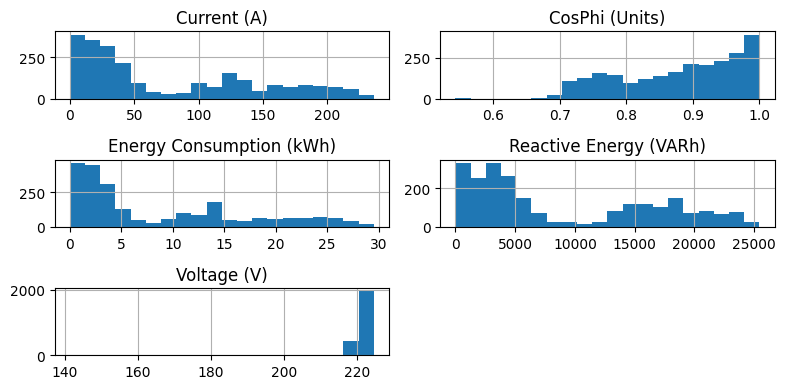

In [6]:
data.hist(figsize=(8, 4), bins=20)  
plt.tight_layout()
plt.show()

## Features Engineering

In [7]:
####################### TODO ################################
...

## Data splitting

In [8]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)  # Data Leakage

In [9]:
timesteps = 10
features = normalized_data.shape[1]

In [10]:
sequences = []
for i in range(len(normalized_data) - timesteps + 1):
    sequences.append(normalized_data[i:i + timesteps])

sequences = np.array(sequences)

In [11]:
train_size = int(len(sequences) * 0.8)
train_data = sequences[:train_size]
test_data = sequences[train_size:]

# Autoencoder LSTM model

In [12]:
input_dim = train_data.shape[1:]  # (timesteps, features)

inputs = Input(shape=input_dim)
encoded = LSTM(256, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(32, activation='relu')(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(256, activation='relu', return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(features))(decoded)

lstm_autoencoder = Model(inputs, outputs)
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 256)           268288    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           197120    
                                                                 
 lstm_2 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 32)            0         
 r)                                                              
                                                             

In [13]:

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,         
    patience=3,          
    min_lr=1e-6          
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,        
    restore_best_weights=True  
)

history = lstm_autoencoder.fit(
    train_data, train_data,
    epochs=100,               
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[reduce_lr, early_stopping] 
)

Epoch 1/100
48/48 [==============================] - 14s 124ms/step - loss: 0.2367 - val_loss: 0.1225 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 4s 88ms/step - loss: 0.1022 - val_loss: 0.0786 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 4s 79ms/step - loss: 0.0751 - val_loss: 0.0481 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 4s 79ms/step - loss: 0.0288 - val_loss: 0.0237 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 4s 79ms/step - loss: 0.0219 - val_loss: 0.0216 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - 4s 80ms/step - loss: 0.0231 - val_loss: 0.0294 - lr: 0.0010
Epoch 7/100
48/48 [==============================] - 4s 82ms/step - loss: 0.0227 - val_loss: 0.0191 - lr: 0.0010
Epoch 8/100
48/48 [==============================] - 4s 76ms/step - loss: 0.0166 - val_loss: 0.0156 - lr: 0.0010
Epoch 9/100
48/48 [==============================] - 4s 80ms/step - loss: 0.0133 - val_loss: 0

### Plot loss

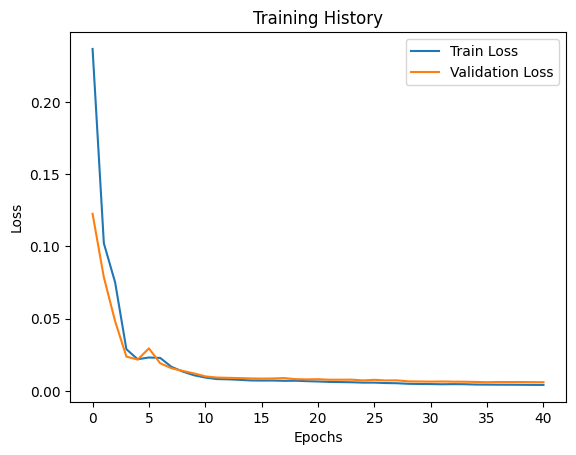

In [14]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Plot Reconstruction Error Distribution

In [15]:
# Evaluate the model on test data
reconstructions = lstm_autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - reconstructions, 2), axis=(1, 2))  # MSE across timesteps and features

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 95)  # 95th percentile as anomaly threshold

# Identify anomalies
anomalies = mse > threshold
anomaly_indices = np.where(anomalies)[0]

print(f"Detected {len(anomaly_indices)} anomalies out of {len(test_data)} samples.")

15/15 [==============================] - 1s 20ms/step
Detected 24 anomalies out of 479 samples.


## Plot True Data, Reconstructed Data and anomalies

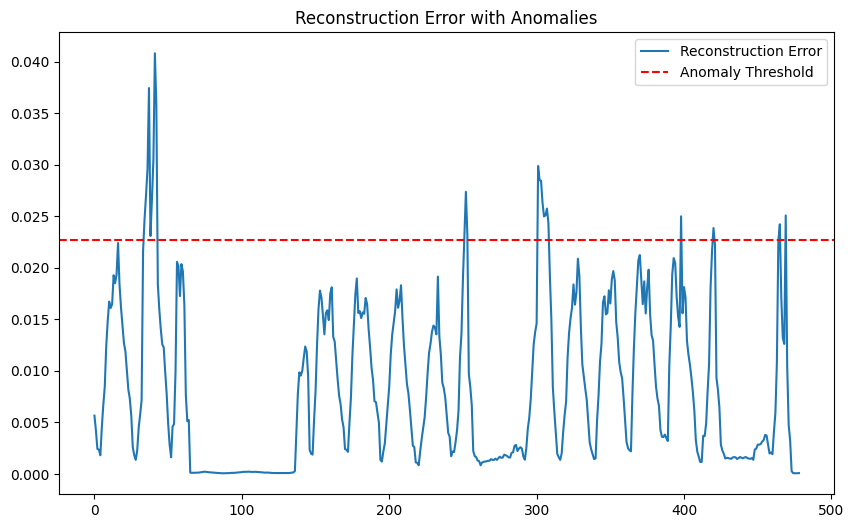

In [16]:
# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error with Anomalies')
plt.legend()
plt.show()

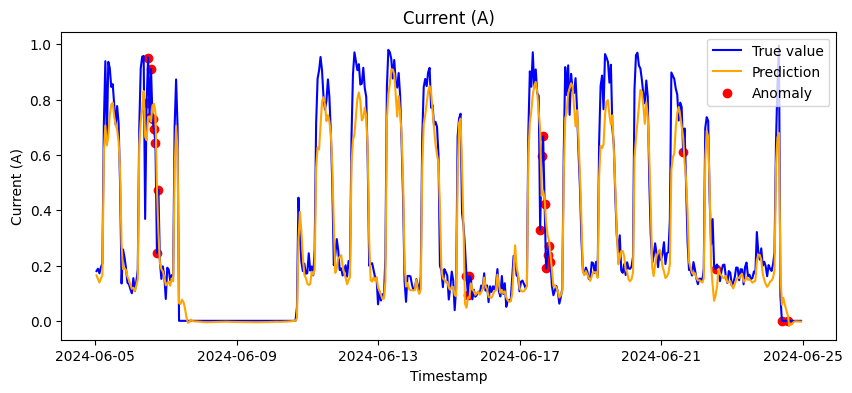

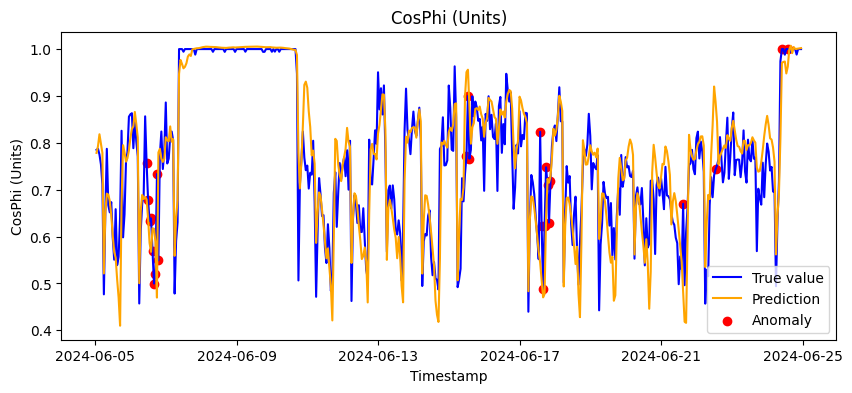

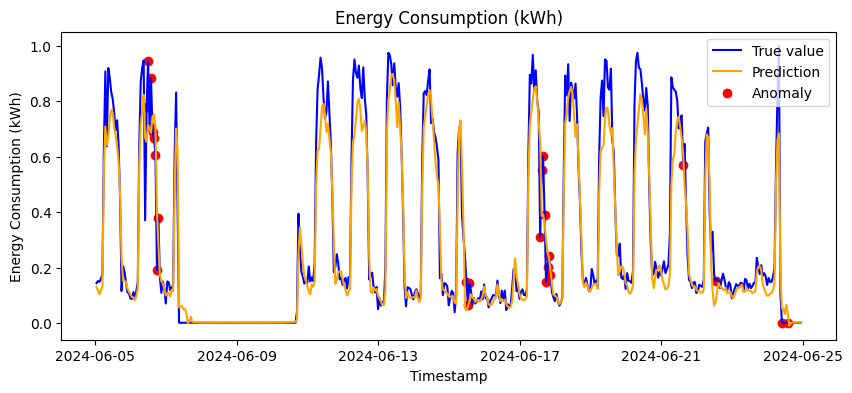

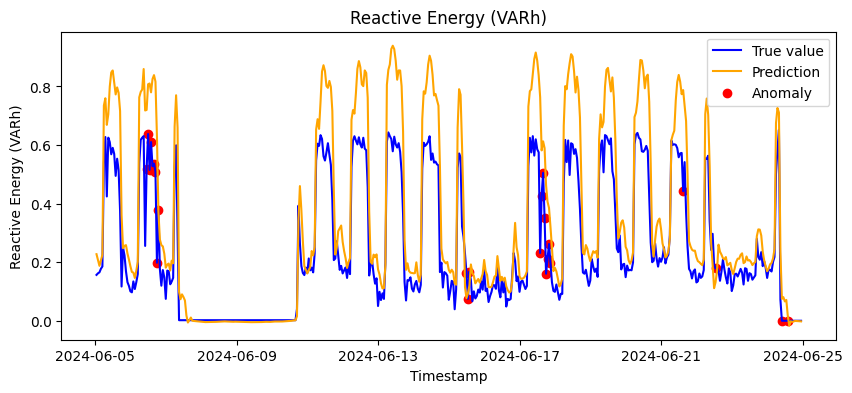

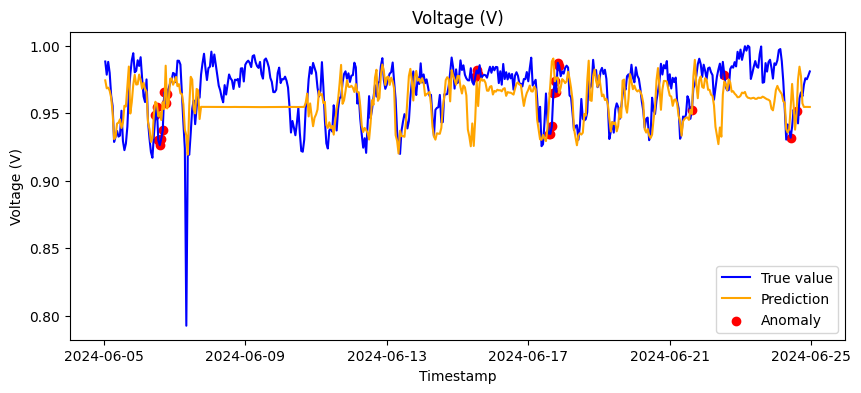

In [17]:
def plot_feature_anomalies(feature_index, feature_name, true_data, predicted_data, anomalies, timestamps):
    plt.figure(figsize=(10, 4))
    
    # Plot true values and predictions
    plt.plot(timestamps, true_data[:, feature_index], label='True value', color='blue')
    plt.plot(timestamps, predicted_data[:, feature_index], label='Prediction', color='orange')
    
    # Highlight anomalies
    anomaly_indices = np.where(anomalies)[0]
    plt.scatter(
        timestamps[anomaly_indices],
        true_data[anomaly_indices, feature_index],
        color='red',
        label='Anomaly'
    )
    
    # Add labels and legend
    plt.title(feature_name)
    plt.xlabel('Timestamp')
    plt.ylabel(feature_name)
    plt.legend()
    plt.show()

# Adjusted for the data in your test set
# Test data timestamps correspond to the range from the 20% split
test_timestamps = timestamps[len(timestamps) - len(test_data):]

# Plot for all features
for i, feature in enumerate(data.columns):
    plot_feature_anomalies(
        feature_index=i,
        feature_name=feature,
        true_data=test_data[:, -1, :],
        predicted_data=reconstructions[:, -1, :],
        anomalies=anomalies,
        timestamps=test_timestamps
    )
